In [18]:
# !pip install torch timm

In [19]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm import tqdm
import torch.nn.functional as F

# from dataset import LensDataset

In [20]:
# import torch.multiprocessing as mp

# mp.set_start_method("spawn", force=True)

In [21]:
!pip install wandb
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: samkitshah1262 (samkitshah1262-warner-bros-discovery) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [22]:
wandb.init(project="grayscale-image-classification", entity="samkitshah1262-warner-bros-discovery")

In [23]:
# import gdown

# url = "https://drive.google.com/uc?id=12p4fMT2HmiDtu-PL_VNiByXxZnaBle84"
# output = "dataset.zip"
# gdown.download(url, output)
# !unzip -q dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=12p4fMT2HmiDtu-PL_VNiByXxZnaBle84
From (redirected): https://drive.google.com/uc?id=12p4fMT2HmiDtu-PL_VNiByXxZnaBle84&confirm=t&uuid=185cf4c6-714a-46c4-9b39-140120f69f62
To: /Users/sshah/2024/projects/gsoc/ml4sci/common/dataset.zip
  0%|          | 1.57M/1.13G [00:01<13:35, 1.38MB/s]

KeyboardInterrupt: 

  0%|          | 1.57M/1.13G [00:11<13:35, 1.38MB/s]

In [24]:
set_images_no = []
for i in range(10):
    set_images_no.append(np.load(f"dataset/train/no/{i+1}.npy"))
set_images_sphere = []
for i in range(10):
    set_images_sphere.append(np.load(f"dataset/train/sphere/{i+1}.npy"))
set_images_vortex = []
for i in range(10):
    set_images_vortex.append(np.load(f"dataset/train/vort/{i+1}.npy"))

In [25]:
img = np.load("dataset/train/no/1.npy")  # Load .npy file
img = torch.tensor(img, dtype=torch.float32)
img.shape

torch.Size([1, 150, 150])

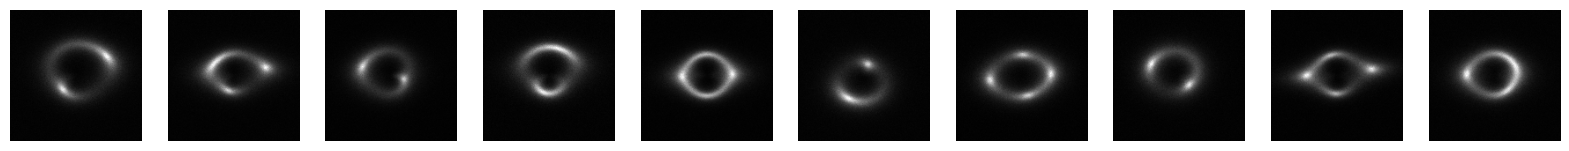

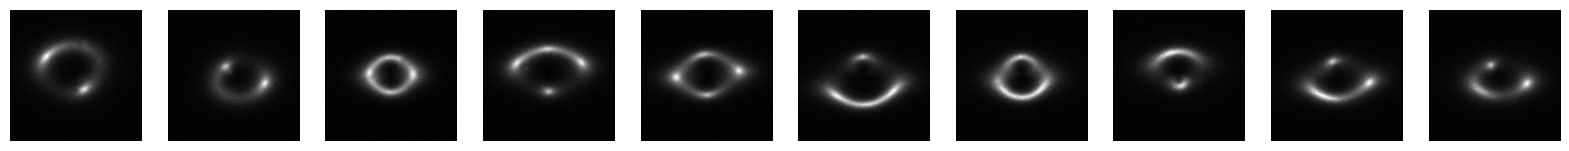

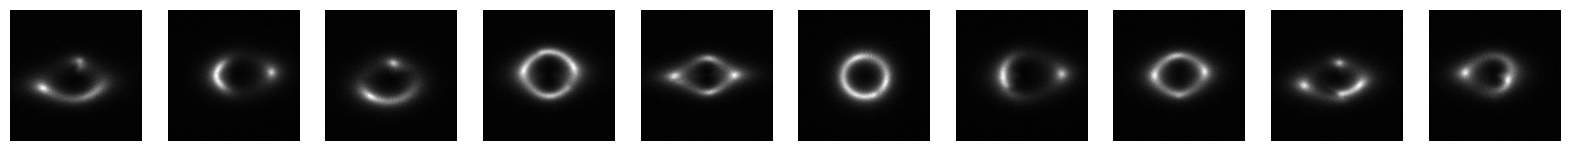

In [26]:
# show 10 images in a subplot for each category give name as well
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(set_images_no[i][0], cmap='gray')
    axs[i].axis('off')
plt.show()

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(set_images_sphere[i][0], cmap='gray')
    axs[i].axis('off')
plt.show()

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(set_images_vortex[i][0], cmap='gray')
    axs[i].axis('off')

plt.show()

In [27]:
def load_data(data_dir):
    """ Loads .npy files and assigns labels based on folder names. """
    file_paths, labels = [], []

    class_names = ["no", "sphere", "vort"]
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith('.npy'):
                file_paths.append(os.path.join(class_dir, file))
                labels.append(label_map[class_name])

    return file_paths, labels, label_map


In [28]:
def repeat_channels(x):
    if x.ndimension() == 2:  # If shape is (H, W)
        x = x.unsqueeze(0)  # Add a channel dimension → (1, H, W)
    return x.repeat(3, 1, 1)  # C  # Convert (1, H, W) → (3, H, W)

# Updated transform without lambda
transform = transforms.Compose([
    transforms.Lambda(repeat_channels),  # Use named function
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [29]:
import numpy as np
import torch
from torch.utils.data import Dataset


class LensDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = np.load(self.file_paths[idx])  # Load .npy file
        img = torch.tensor(img, dtype=torch.float32)  # Convert to tensor
        # img = img.unsqueeze(1)  # Add channel dimension (1, H, W)

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label


In [37]:
train_files, train_labels, label_map = load_data('dataset/train')
val_files, val_labels, _ = load_data('dataset/val')

# Create Datasets
train_dataset = LensDataset(train_files, train_labels, transform)
val_dataset = LensDataset(val_files, val_labels, transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


In [38]:
print(train_dataset[0][0].shape)

torch.Size([3, 150, 150])


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=3)
model = torch.compile(model)
model.conv_stem = nn.Conv2d(3, 40, kernel_size=3, stride=2, padding=1, bias=False)
model = model.to(device)


In [40]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10)


In [41]:
import time

def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    total_batches = len(train_loader)

    start_time = time.time()

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        all_preds.append(outputs.detach().cpu())
        all_labels.append(labels.detach().cpu())

        if batch_idx % 10 == 0 or batch_idx == total_batches - 1:
            print(f"Batch [{batch_idx+1}/{total_batches}] - Loss: {loss.item():.4f}")

    epoch_time = time.time() - start_time
    print(f"⏳ Epoch took {epoch_time:.2f} seconds")

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    all_preds_probs = F.softmax(all_preds, dim=1)
    auc = roc_auc_score(all_labels.numpy(), all_preds_probs.numpy(), multi_class='ovr')
    return running_loss / total_batches, auc

In [42]:
def validate_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    total_batches = len(val_loader)

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

            if batch_idx % 10 == 0 or batch_idx == total_batches - 1:
                print(f"Validation Batch [{batch_idx+1}/{total_batches}] - Loss: {loss.item():.4f}")

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    all_preds_probs = F.softmax(all_preds, dim=1)
    auc = roc_auc_score(all_labels.numpy(), all_preds_probs.numpy(), multi_class='ovr')
    return running_loss / total_batches, auc

In [43]:
num_epochs = 20
best_auc = 0.0

log_file = "training_log.txt"

for epoch in tqdm(range(num_epochs)):

    train_loss, train_auc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_auc = validate_epoch(model, val_loader, criterion)

    log_message = f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train AUC={train_auc:.4f} | Val Loss={val_loss:.4f}, Val AUC={val_auc:.4f}"

    print(log_message)
    with open(log_file, "a") as f:
        f.write(log_message + "\n")

    scheduler.step()

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved!")


  0%|          | 1.57M/1.13G [01:31<18:11:41, 17.2kB/s]


Batch [1/1875] - Loss: 4.0361
Batch [11/1875] - Loss: 2.9604
Batch [21/1875] - Loss: 3.6657
Batch [31/1875] - Loss: 4.0163
Batch [41/1875] - Loss: 2.7496
Batch [51/1875] - Loss: 3.1625
Batch [61/1875] - Loss: 2.0334
Batch [71/1875] - Loss: 1.6622
Batch [81/1875] - Loss: 2.8126
Batch [91/1875] - Loss: 1.2741
Batch [101/1875] - Loss: 1.9137
Batch [111/1875] - Loss: 2.1295
Batch [121/1875] - Loss: 1.4236
Batch [131/1875] - Loss: 2.6607
Batch [141/1875] - Loss: 2.6131
Batch [151/1875] - Loss: 1.2078
Batch [161/1875] - Loss: 2.1076
Batch [171/1875] - Loss: 2.0526
Batch [181/1875] - Loss: 1.7383
Batch [191/1875] - Loss: 1.9131
Batch [201/1875] - Loss: 2.0172
Batch [211/1875] - Loss: 1.3755
Batch [221/1875] - Loss: 1.5550
Batch [231/1875] - Loss: 1.3727
Batch [241/1875] - Loss: 1.2009
Batch [251/1875] - Loss: 1.0383
Batch [261/1875] - Loss: 1.1703
Batch [271/1875] - Loss: 1.3883
Batch [281/1875] - Loss: 1.5670
Batch [291/1875] - Loss: 1.2731
Batch [301/1875] - Loss: 1.1141
Batch [311/1875] - 

  0%|          | 0/20 [1:11:33<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def plot_roc_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(8, 6))

    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.title("ROC Curves")
    plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize

def evaluate(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Convert outputs to probabilities (Softmax)
            probs = torch.softmax(outputs, dim=1)  # Ensure predictions sum to 1

            all_preds.append(probs.cpu().numpy())  # Store probabilities
            all_labels.append(labels.cpu().numpy())  # Store true labels

    all_preds = np.concatenate(all_preds)  # Shape: (N, num_classes)
    all_labels = np.concatenate(all_labels)  # Shape: (N,)

    # One-hot encode labels for ROC curve
    all_labels = label_binarize(all_labels, classes=[0, 1, 2])

    plot_roc_curve(all_labels, all_preds, class_names=["No Substructure", "Subhalo", "Vortex"])

evaluate(model, val_loader)

In [ ]:
!pip install optuna
import optuna
from torch.utils.data import Subset

In [ ]:
def objective(trial):
    """Hyperparameter optimization function with WandB logging."""
    # Sample hyperparameters
    lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Initialize WandB for the trial
    wandb.init(project="grayscale-image-classification", config={
        "learning_rate": lr,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "trial_number": trial.number
    })

    # DataLoader (Use subset for faster tuning)
    subset_indices = np.random.choice(len(train_files), int(0.2 * len(train_files)), replace=False)
    train_subset = Subset(LensDataset(train_files, train_labels, transform=None), subset_indices)
    val_subset = LensDataset(val_files, val_labels, transform=None)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=3)
    model.conv_stem = nn.Conv2d(3, 40, kernel_size=3, stride=2, padding=1, bias=False)  # Adjust input for grayscale
    model = model.to(device)

    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=5)

    # Training (3 epochs for tuning)
    for epoch in range(3):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        wandb.log({"train_loss": avg_loss, "epoch": epoch})

        scheduler.step()

    # Validation AUC Calculation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    auc_score = roc_auc_score(all_labels, all_preds, multi_class="ovr")

    # Log validation results
    wandb.log({"val_auc": auc_score})

    return auc_score

# ===========================
# Run Optuna Study
# ===========================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # Run 20 trials

# ===========================
# Print Best Hyperparameters
# ===========================
print("\nBest Hyperparameters:")
print(study.best_params)

# Log Best Hyperparameters to WandB
wandb.config.update(study.best_params)
wandb.finish()